In [1]:
using LinearAlgebra  #####Son las paqueterias que uso, para instalar una paqueteria basta colocar Pkg.add("Nombre_de_la_paqueteria")
using Plots
using SpecialFunctions: gamma
using Random, Distributions
using Alert

In [2]:
function covariance_S(X::Array{Float64,1},Y::Array{Float64,1})
    n=length(X)
    cov=0
    Xm=mean(X)
    Ym=mean(Y)
    for i=1:n
        cov=(X[i]-Xm)*(Y[i]-Ym) + cov
    end
    return cov/n
end

covariance_S (generic function with 1 method)

In [3]:
function OUH(x0::Float64,γ::Float64,t::AbstractArray,Δt::Float64,η::Float64,cte::Float64=0.0) #Proceso de Ornstein–Uhlenbeck
    x=Vector{Float64}(undef, length(t)) #Definimos un vector lleno de basura para luego sobre escribir en el 
    x[1]=x0    #La primera entrada es la condicion inicial del Proceso de Ornstein–Uhlenbeck
    
    for i=1:length(t)-1                 #Usamos un for para poder hacer el proceso
        x0=x0-γ*Δt*(x0-cte)+(sqrt(2*η*Δt)*randn()) # Es el proceso de Ornstein–Uhlenbeck que depende del paso anterior 
        @inbounds x[1+i]=x0                 #@inbounds ignora si la lista tiene el tamaño adecuado y sobreescribimos en la lista basura
    end
    return x                          # Devolvemos la caminata de Ornstein–Uhlenbeck
end

OUH (generic function with 2 methods)

In [4]:
U(K::Float64,T::Float64)=[T/sqrt(K^2+T^2),0,K/sqrt(K^2+T^2)] #Es la función que da el eje de rotación dependiente de la curvatura y la torsión
ϕ(K::Float64,T::Float64,Δt::Float64)=Δt*sqrt(K^2+T^2) #Es la función que da el angulo de rotación

ψ0(ϕ0,ϕ1,u,w)=2*acos(cos(ϕ1/2)*cos(ϕ0/2)-sin(ϕ1/2)*sin(ϕ0/2)*dot(u,w)) # Es la función para generar el primer angulo  resultado de dos "matrices/cuaternios"

# Son las funciones para generar el primer eje resultado de dos "matrices/cuaternios"
w1x(ϕ0,ϕ1,u,w,ψ0)=(cos(ϕ1/2)*sin(ϕ0/2)*w[1]+cos(ϕ0/2)*sin(ϕ1/2)*u[1])*csc(ψ0/2) 
w1y(ϕ0,ϕ1,u,w,ψ0)=((u[3]*w[1]-w[3]*u[1])*sin(ϕ1/2)*sin(ϕ0/2))*csc(ψ0/2)
w1z(ϕ0,ϕ1,u,w,ψ0)=(cos(ϕ1/2)*sin(ϕ0/2)*w[3]+cos(ϕ0/2)*sin(ϕ1/2)*u[3])*csc(ψ0/2)


ψn(ϕ0,ϕ1,u,w)=2*acos(cos(ϕ1/2)*cos(ϕ0/2)-sin(ϕ1/2)*sin(ϕ0/2)*dot(u,w)) # Es la función para generar los otros angulos

# Son las funciones para generar los otros ejes resultado
wnx(ϕ0,ϕ1,u,w,ψ0)=(cos(ϕ1/2)*sin(ϕ0/2)*w[1]+cos(ϕ0/2)*sin(ϕ1/2)*u[1]-(w[2]*u[3])*sin(ϕ0/2)*sin(ϕ1/2))*csc(ψ0/2)
wny(ϕ0,ϕ1,u,w,ψ0)=(cos(ϕ1/2)*sin(ϕ0/2)*w[2]+(u[3]*w[1]-w[3]*u[1])*sin(ϕ1/2)*sin(ϕ0/2))*csc(ψ0/2)
wnz(ϕ0,ϕ1,u,w,ψ0)=(cos(ϕ1/2)*sin(ϕ0/2)*w[3]+cos(ϕ0/2)*sin(ϕ1/2)*u[3]+(w[2]*u[1])*sin(ϕ0/2)*sin(ϕ1/2))*csc(ψ0/2)


wnz (generic function with 1 method)

In [5]:
#Acomodamos el eje y el angulo de rotacion en una matriz de euler-rodriguez

MatRot(ω,Ψ)=[ cos(Ψ)+ω[1]^2*(1-cos(Ψ)) ω[1]*ω[2]*(1-cos(Ψ))-ω[3]*sin(Ψ) ω[1]*ω[3]*(1-cos(Ψ))+ω[2]*sin(Ψ);
                ω[2]*ω[1]*(1-cos(Ψ))+ω[3]*sin(Ψ) cos(Ψ)+ω[2]^2*(1-cos(Ψ)) ω[2]*ω[3]*(1-cos(Ψ))-ω[1]*sin(Ψ);
                    ω[3]*ω[1]*(1-cos(Ψ))-ω[2]*sin(Ψ) ω[3]*ω[2]*(1-cos(Ψ))+ω[1]*sin(Ψ) cos(Ψ)+ω[3]^2*(1-cos(Ψ))]

MatRot (generic function with 1 method)

In [6]:
function eigenf(tiradas::Int64,PASO::Int64)


    θ=Array{Float64,1}(undef,tiradas)

    for j=1:tiradas

        K=OUH(k0,γK,t[1:PASO],Δt,ηK,ctek)
        T=OUH(t0,γT,t[1:PASO],Δt,ηT,ctet)

        Un=U.(K,T)
        ϕn=ϕ.(K,T,Δt)

        ω=Array{Array{Float64,1},1}(undef,PASO)
        Ψ=Array{Float64,1}(undef,PASO)
        ω[1]=Un[1]
        Ψ[1]=ϕn[1]

        ψ1=ψ0(ϕn[1],ϕn[2],Un[1],Un[2])
        w=[w1x(ϕn[1],ϕn[2],Un[2],Un[1],ψ1),
            w1y(ϕn[1],ϕn[2],Un[2],Un[1],ψ1),
            w1z(ϕn[1],ϕn[2],Un[2],Un[1],ψ1)];
        ω[2]=w
        Ψ[2]=ψ1
        for i=3:PASO
            ψ=ψn(ψ1,ϕn[i],Un[i],w)
            w=[wnx(ψ1,ϕn[i],Un[i],w,ψ),wny(ψ1,ϕn[i],Un[i],w,ψ),wnz(ψ1,ϕn[i],Un[i],w,ψ)]
            ω[i]=w
            Ψ[i]=ψ1
            ψ1=ψ
        end
        θ[j]=Ψ[end]
    end
    return θ
end

eigenf (generic function with 1 method)

In [7]:
function serie_tiempo_θ(PASO);     # Nos da la serie de tiempo de las eigenfases
    θ=Array{Float64,1}(undef,PASO)

    K=OUH(k0,γK,t[1:PASO],Δt,ηK,ctek)
    T=OUH(t0,γT,t[1:PASO],Δt,ηT,ctet)

    Un=U.(K,T)
    ϕn=ϕ.(K,T,Δt)

    ω=Array{Array{Float64,1},1}(undef,PASO)
    Ψ=Array{Float64,1}(undef,PASO)
    ω[1]=Un[1]
    Ψ[1]=ϕn[1]
    
    θ[1]=Ψ[1]     #Agregamos la primer eigenfase
    
    ψ1=ψ0(ϕn[1],ϕn[2],Un[1],Un[2])
    w=[w1x(ϕn[1],ϕn[2],Un[2],Un[1],ψ1),
        w1y(ϕn[1],ϕn[2],Un[2],Un[1],ψ1),
        w1z(ϕn[1],ϕn[2],Un[2],Un[1],ψ1)];
    ω[2]=w
    Ψ[2]=ψ1
    
    θ[2]=Ψ[2]     #Agregamos la segunda eigenfase
    
    for i=3:PASO   #Agregamos LOS demas eigenfases
        ψ=ψn(ψ1,ϕn[i],Un[i],w)
        w=[wnx(ψ1,ϕn[i],Un[i],w,ψ),wny(ψ1,ϕn[i],Un[i],w,ψ),wnz(ψ1,ϕn[i],Un[i],w,ψ)]
        ω[i]=w
        Ψ[i]=ψ1
        ψ1=ψ
        θ[i]=Ψ[i]
    end
    
    return θ
end

serie_tiempo_θ (generic function with 1 method)

In [8]:
k0=0.01
t0=0.01

γK=2.0
γT=2.0

ηK=1.0
ηT=1.0

N=80.0

Δt=0.001

t=0:Δt:N

ctek=3.0
ctet=3.0

K=OUH(k0,γK,t,Δt,ηK,ctek)
T=OUH(t0,γT,t,Δt,ηT,ctet)
plot(t,K,legend=false)
plot!(t,T,legend=false)

In [9]:
tiradas=3000
PASO=length(t)
#PASO=300

80001

In [10]:
@time θ = eigenf(tiradas,PASO);

668.371193 seconds (5.27 G allocations: 142.948 GiB, 4.73% gc time)


In [11]:
Sp=vcat(θ,-θ,zeros(length(θ)))
Sp=angle.(exp.(-im*Sp));

  3.542017 seconds (7.10 M allocations: 367.656 MiB, 3.24% gc time)


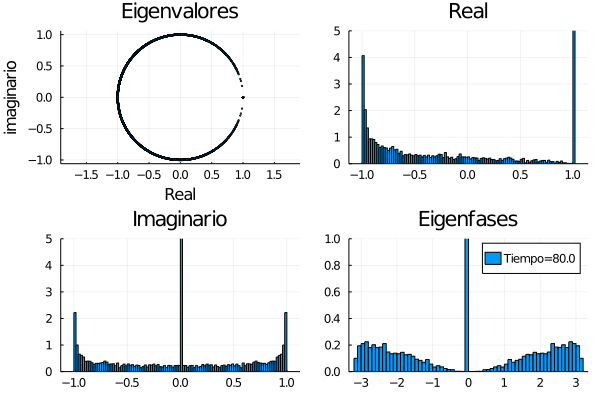

In [12]:
@time begin  
l = @layout grid(2,2,heights=[0.5,0.5,0.5,0.5])
Q1=scatter(real(exp.(-im*Sp)),imag(exp.(-im*Sp)),legend=false,aspect_ratio=:equal,markersize=1,xlabel="Real",ylabel="imaginario",title="Eigenvalores")
Q2=histogram(real(exp.(-im*Sp)),normalized=true,title="Real",legend=false,bins=100,ylims=(0,5))
Q3=histogram(imag(exp.(-im*Sp)),normalized=true,title="Imaginario",legend=false,bins=100,ylims=(0,5))
Q4=histogram(Sp,normalized=true,bins=60,label="Tiempo=$(t[PASO])",title="Eigenfases",ylims=(0,1),xlims=(-(1*π+0.2),1*π+0.2))
plot(Q1,Q2,Q3,Q4,layout=l)
#savefig("Eigenvalores_Completo_3D_gamK=$(γK)_gam=$(γT)_etaK=$(ηK)_etaT=$(ηT)_k0=$(k0)_t0=$(t0)_ck=_$(ctek)ct=$(ctet).png");
end

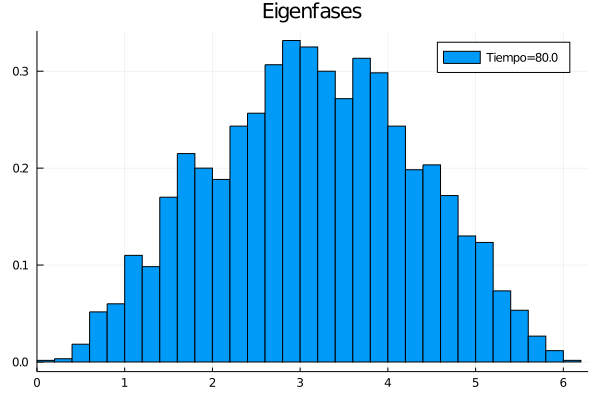

In [13]:
histogram(θ,normalized=true,bins=50,label="Tiempo=$(t[PASO])",title="Eigenfases",xlims=(0,2*π))


In [14]:
#savefig("./Eigen_fases_paso_3.png")

In [15]:
step=1000
tiradas=100
a=2:step:length(t)
length(a)

80

364.581490 seconds (3.25 G allocations: 88.723 GiB, 2.27% gc time)


┌ Info: Saved animation to 
│   fn = C:\Users\sebas\Desktop\tesis\CODIGOS FINALES\Animacion_Prueba_3D_gamK=2.0_gam=2.0_etaK=1.0_etaT=1.0_k0=0.01_t0=0.01_ck=_3.0ct=3.0.gif
└ @ Plots C:\Users\sebas\.julia\packages\Plots\SIQaY\src\animation.jl:104


Plots.AnimatedGif("C:\\Users\\sebas\\Desktop\\tesis\\CODIGOS FINALES\\Animacion_Prueba_3D_gamK=2.0_gam=2.0_etaK=1.0_etaT=1.0_k0=0.01_t0=0.01_ck=_3.0ct=3.0.gif")
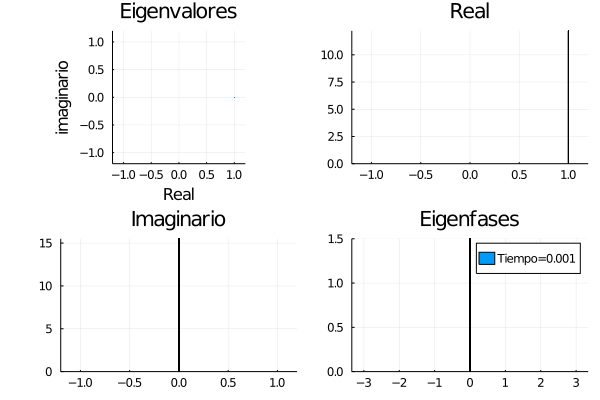

In [42]:
@time begin    
    anim= @animate for j=2:step:length(t)
        θ = eigenf(tiradas,j);
        Sp=vcat(θ,-θ,zeros(length(θ)))
        Sp=angle.(exp.(-im*Sp))
        l = @layout grid(2,2,heights=[0.5,0.5,0.5,0.5])
        Q1=scatter(real(exp.(-im*Sp)),imag(exp.(-im*Sp)),legend=false,aspect_ratio=:equal,markersize=1,xlabel="Real",ylabel="imaginario",title="Eigenvalores",xlims=(-1.2,1.2),ylims=(-1.2,1.2))
        Q2=histogram(real(exp.(-im*Sp)),normalized=true,title="Real",legend=false,bins=100,xlims=(-1.2,1.2),ylims=(0,12.2))
        Q3=histogram(imag(exp.(-im*Sp)),normalized=true,title="Imaginario",legend=false,bins=100,xlims=(-1.2,1.2),ylims=(0,15.5))
        Q4=histogram(Sp,normalized=true,bins=60,label="Tiempo=$(t[j])",title="Eigenfases",xlims=(-(1*π+0.2),1*π+0.2),ylims=(0,1.5))
        plot(Q1,Q2,Q3,Q4,layout=l)
    end
    gif(anim,"./Animacion_Prueba_3D_gamK=$(γK)_gam=$(γT)_etaK=$(ηK)_etaT=$(ηT)_k0=$(k0)_t0=$(t0)_ck=_$(ctek)ct=$(ctet).gif", fps=60)
end

787.863633 seconds (6.93 G allocations: 188.112 GiB, 3.62% gc time)


┌ Info: Saved animation to 
│   fn = C:\Users\sebas\Desktop\tesis\CODIGOS FINALES\Animacion_fases_gamK=2.0_gam=2.0_etaK=1.0_etaT=1.0_k0=0.01_t0=0.01_ck=_3.0ct=3.0.gif
└ @ Plots C:\Users\sebas\.julia\packages\Plots\SIQaY\src\animation.jl:104


Plots.AnimatedGif("C:\\Users\\sebas\\Desktop\\tesis\\CODIGOS FINALES\\Animacion_fases_gamK=2.0_gam=2.0_etaK=1.0_etaT=1.0_k0=0.01_t0=0.01_ck=_3.0ct=3.0.gif")
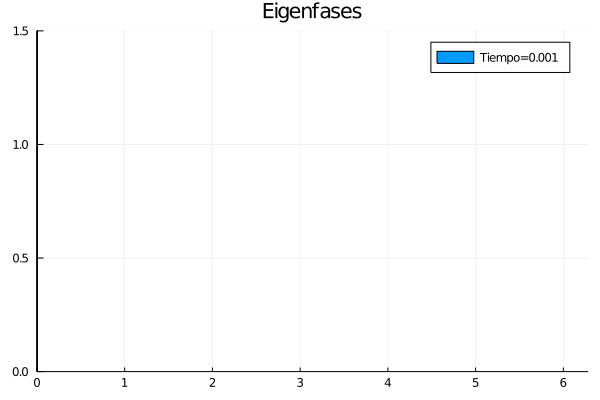

In [17]:
@time begin    
    anim= @animate for j=2:step:length(t)
        θ = eigenf(tiradas,j);
        histogram(θ,normalized=true,bins=60,label="Tiempo=$(t[j])",title="Eigenfases",xlims=(0,2*π),ylims=(0,1.5))
    end
    gif(anim,"./Animacion_fases_gamK=$(γK)_gam=$(γT)_etaK=$(ηK)_etaT=$(ηT)_k0=$(k0)_t0=$(t0)_ck=_$(ctek)ct=$(ctet).gif", fps=60)
end